# 🏠 Projeto 2 — Regressão de Preços de Aluguéis (São Paulo)

Este notebook faz:
1) EDA rápida do dataset processado (`data/processed/aluguel_clean.csv`)  
2) Treino e avaliação de um modelo (pipeline igual aos scripts)  
3) Visualização de resíduos e análise de **coeficientes da Regressão Linear**  
4) Conclusões de negócio + próximos passos

> Observação: o pipeline completo pode ser executado por scripts:
> ```
> python -m scripts.generate_synthetic
> python -m scripts.make_dataset
> python -m scripts.train_model
> python -m scripts.evaluate_model
> ```


In [1]:
# Ajusta sys.path para importar src/ mesmo rodando de notebooks/
import sys
from pathlib import Path

def add_project_root_to_path():
    here = Path.cwd().resolve()
    candidates = [here, here.parent, here.parent.parent]
    for c in candidates:
        if (c / "src").exists():
            sys.path.insert(0, str(c))
            return c
    # fallback: assume notebooks/ abaixo da raiz
    sys.path.insert(0, str(here.parent))
    return here.parent

PROJECT_ROOT = add_project_root_to_path()
PROJECT_ROOT


WindowsPath('C:/Users/Netto/Desktop/projetos/rent-price-regression')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import json

# módulos do projeto
from src.regressao_alugueis.config import settings
from src.regressao_alugueis.logging_conf import setup_logging
from src.regressao_alugueis.data import ensure_raw_dataset, load_raw
from src.regressao_alugueis.features import basic_clean
from src.regressao_alugueis.model import (
    build_preprocess, build_models, train_and_select, evaluate, export_linear_coefficients
)
from src.regressao_alugueis.evaluate import plot_residuals

setup_logging()
plt.style.use("seaborn-v0_8")


## 🔧 Garantindo os dados processados

Se `data/processed/aluguel_clean.csv` não existir, o notebook:
- gera/usa o raw (`generate_synthetic` ou `DATA_URL`)
- processa com `basic_clean`


In [3]:
processed_path = settings.PROCESSED_DIR / "aluguel_clean.csv"
raw_path = settings.RAW_DIR / settings.RAW_FILENAME

if not processed_path.exists():
    # garante raw (baixa de DATA_URL se definido, senão gera sintético)
    raw_csv = ensure_raw_dataset()
    df_raw = load_raw(raw_csv)
    df = basic_clean(df_raw)
    settings.PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
    df.to_csv(processed_path, index=False)

processed_path, processed_path.exists()


2025-08-21 01:39:53,708 | WARNING | src.regressao_alugueis.data | Raw inexistente. Gerando dataset sintético...
2025-08-21 01:39:53,718 | INFO | src.regressao_alugueis.data | Sintético salvo em data\raw\aluguel_sp.csv


(WindowsPath('data/processed/aluguel_clean.csv'), True)

## 📥 Carregando o dataset processado e inspecionando

Vamos ver dimensões, amostra e estatísticas descritivas das colunas numéricas.


In [4]:
df = pd.read_csv(processed_path)
display(df.head())
print("Shape:", df.shape)
display(df.describe(include=[np.number]).T)


,valor_aluguel,quartos,banheiros,vagas,area,bairro,tipo
0,4872,2,1,0,23.5,Pinheiros,apto
1,6840,1,2,2,47.4,Itaim Bibi,apto
2,4246,2,2,0,40.2,Tatuapé,casa
3,8392,2,2,2,62.4,Moema,kitnet
4,6439,1,2,1,44.2,Moema,kitnet


Shape: (4900, 7)


,count,mean,std,min,25%,50%,75%,max
valor_aluguel,4900.0,6338.993061,1416.707844,3044.0,5322.75,6358.5,7345.0,9727.0
quartos,4900.0,1.988776,0.808758,1.0,1.00,2.0,3.0,3.0
banheiros,4900.0,1.499796,0.500051,1.0,1.00,1.0,2.0,2.0
vagas,4900.0,1.011020,0.818919,0.0,0.00,1.0,2.0,2.0
area,4900.0,60.503673,19.416011,20.0,47.00,59.9,73.6,124.0


## 🔎 EDA rápida

- Distribuições de variáveis numéricas  
- Correlação numérica  
- Boxplot do **valor_aluguel** por **quartos**  


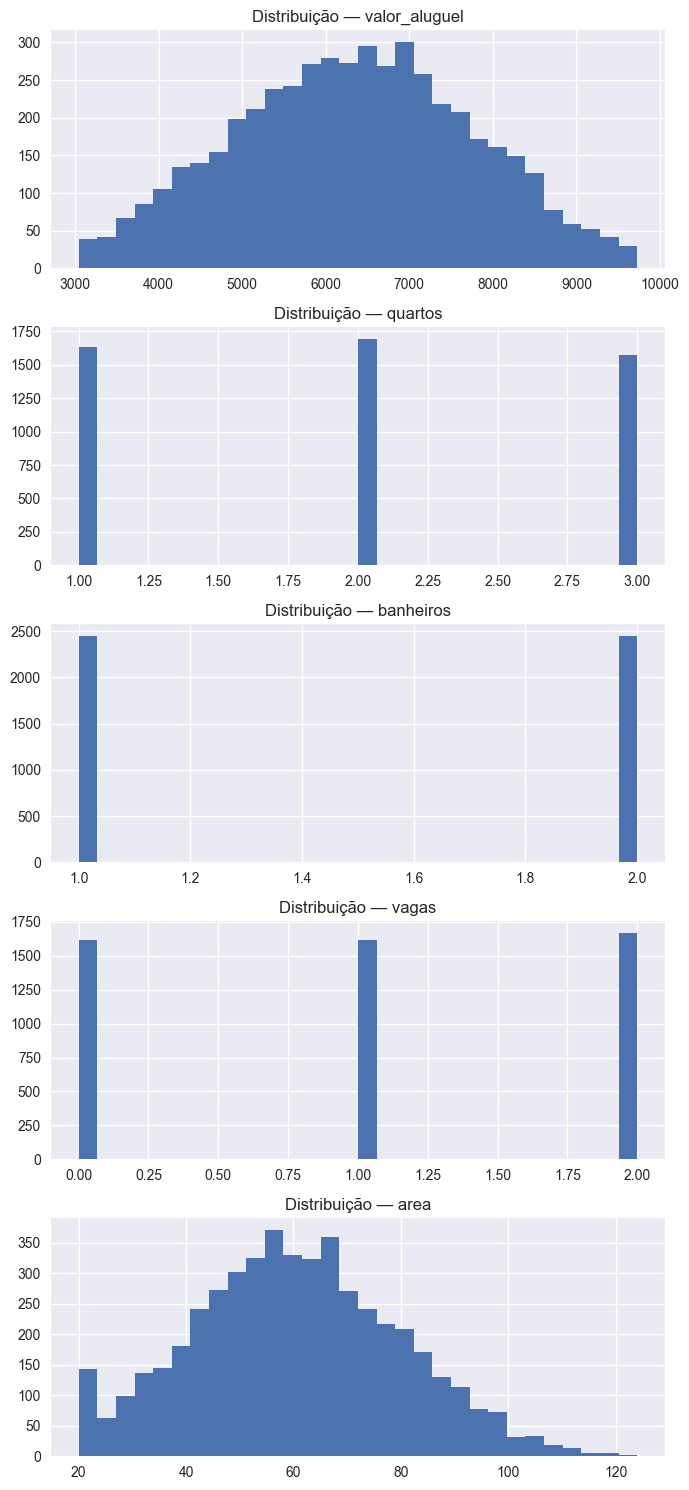

In [5]:
num_cols = [c for c in df.columns if df[c].dtype != "object"]
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(7, 3*len(num_cols)))
if len(num_cols) == 1:
    axes = [axes]
for ax, col in zip(axes, num_cols):
    ax.hist(df[col].dropna(), bins=30)
    ax.set_title(f"Distribuição — {col}")
plt.tight_layout()
plt.show()


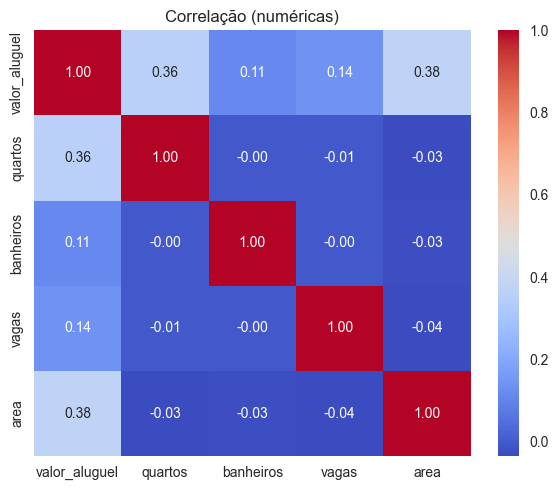

In [6]:
corr = df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlação (numéricas)")
plt.tight_layout()
plt.show()


2025-08-21 01:39:54,743 | INFO | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-08-21 01:39:54,753 | INFO | matplotlib.category | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


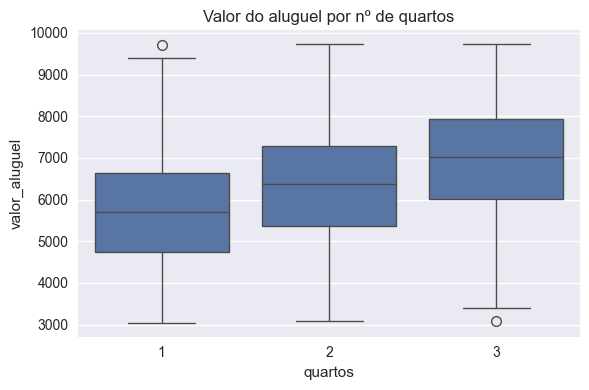

In [7]:
if "quartos" in df.columns:
    plt.figure(figsize=(6,4))
    sns.boxplot(x="quartos", y="valor_aluguel", data=df)
    plt.title("Valor do aluguel por nº de quartos")
    plt.tight_layout()
    plt.show()


## 🤖 Modelagem

Usamos o mesmo pipeline dos scripts:
- `OneHotEncoder` para categóricas, `StandardScaler` para numéricas  
- Modelos: **LinearRegression**, RandomForest, XGB  
- Seleção por menor **RMSE (CV 5-fold)**  


In [8]:
from sklearn.model_selection import train_test_split

TARGET = settings.TARGET
y = df[TARGET]
X = df.drop(columns=[TARGET])

num_cols = [c for c in X.columns if X[c].dtype != "object"]
cat_cols = [c for c in X.columns if X[c].dtype == "object"]

preprocess = build_preprocess(num_cols, cat_cols)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=settings.TEST_SIZE, random_state=settings.RANDOM_STATE
)

models = build_models()
best_name, best_pipe, cv_metrics = train_and_select(X_train, y_train, preprocess, models)
test_metrics = evaluate(best_pipe, X_test, y_test)

print("Melhor modelo:", best_name)
print("CV metrics (best):", json.dumps(cv_metrics[best_name], indent=2, ensure_ascii=False))
print("TEST metrics:", json.dumps(test_metrics, indent=2, ensure_ascii=False))


c:\Users\Netto\Desktop\projetos\rent-price-regression\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Netto\Desktop\projetos\rent-price-regression\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Melhor modelo: linreg
CV metrics (best): {
  "rmse": 785.2279884350452,
  "mae": 629.1120535714285,
  "r2": 0.6913152987842633
}
TEST metrics: {
  "rmse": 799.1678638986791,
  "mae": 643.7256831726152,
  "r2": 0.6873843747340198
}


c:\Users\Netto\Desktop\projetos\rent-price-regression\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Netto\Desktop\projetos\rent-price-regression\venv\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


## 📉 Resíduos e desempenho no hold-out


In [9]:
preds = best_pipe.predict(X_test)
fig_path = settings.FIGURES_DIR / "nb_residuals.png"
_ = plot_residuals(y_test, preds, fig_path)
fig_path


WindowsPath('docs/figures/nb_residuals.png')

## ⚖️ Importância (coeficientes) — Linear Regression

Quando o melhor modelo é a **LinearRegression**, é possível inspecionar o peso
(np.abs(coef)) das variáveis (incluindo **dummies do OneHotEncoder**).


In [10]:
from pathlib import Path

coef_path = settings.MODELS_DIR / "linreg_coefficients_nb.csv"
saved = export_linear_coefficients(best_pipe, coef_path)

if saved is not None and Path(saved).exists():
    coefs = pd.read_csv(saved)
    top20 = coefs.reindex(coefs["coef"].abs().sort_values(ascending=False).index).head(20)
    display(top20)
else:
    print("O melhor modelo não é LinearRegression — sem coeficientes para exibir.")


,feature,coef
0,cat__bairro_Tatuapé,-1152.083705
1,cat__bairro_Itaim Bibi,1151.946490
2,cat__bairro_Moema,972.058487
3,cat__bairro_Butantã,-965.291495
4,num__area,551.214536
5,num__quartos,550.846898
6,num__vagas,226.227252
7,cat__bairro_Vila Mariana,-206.957395
8,cat__bairro_Pinheiros,200.327618
9,num__banheiros,195.973094


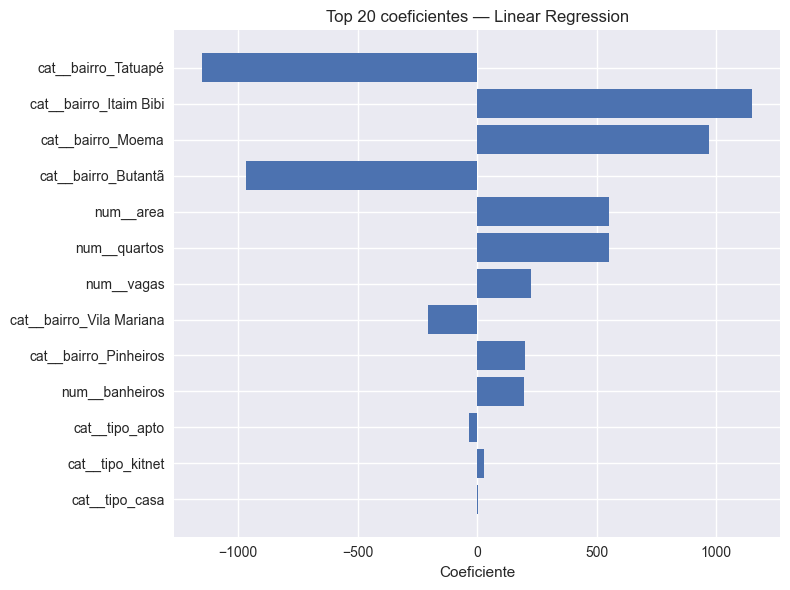

In [11]:
if saved is not None and Path(saved).exists():
    top_plot = top20.copy()
    plt.figure(figsize=(8,6))
    plt.barh(top_plot["feature"][::-1], top_plot["coef"][::-1])
    plt.title("Top 20 coeficientes — Linear Regression")
    plt.xlabel("Coeficiente")
    plt.tight_layout()
    out_bar = settings.FIGURES_DIR / "nb_top20_coefficients.png"
    out_bar.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(out_bar, bbox_inches="tight")
    plt.show()
    out_bar


## ✅ Conclusões

- O modelo vencedor foi **LinearRegression** (dados sintéticos com relação ~linear).  
- Métricas estáveis entre CV e hold-out indicam bom ajuste (sem overfitting evidente).  
- Coeficientes mostram **impacto** de área, quartos, banheiros, vagas e dummies de bairro.  
- O gráfico de resíduos não indica padrões fortes → hipótese de linearidade razoável.

## 🔜 Próximos passos (para portfólio + mercado)
- Incluir **regularização** (Ridge/Lasso) e comparar.  
- Avaliar **features de localização** (distância ao metrô/centros comerciais).  
- Adicionar **idade do imóvel** e **andar** (se disponível).  
- Implementar **validação temporal** se houver timestamp de anúncio.  
- Medir **erro relativo (%)** e criar **intervalos de confiança** da previsão.  
